<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.Auto Encoder

AutoEncoder generally performs learning to minimize mean squared errors between input and output.

Thus, the output of the AutoEncoder is the same as the input.

The features of the hidden layer are applied to various tasks.

※If you want to perform learning, create a source file.

Import of required library.

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from skimage import io

print(torch.__version__)
if (torch.cuda.is_available):
    print('Cuda is available')
else:
    print('Cuda is not avaibalbe')

1.1.0
Cuda is available


Fixed seed value for random numbers.

In [0]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Parameter definition.

In [0]:
BATCH_SIZE      = 1000
WEIGHT_DECAY    = 0.001
LEARNING_RATE   = 0.01
EPOCH           = 500
NUM_WORKERS     = 2

Reading dataset.

In [0]:
mnist_train = dsets.MNIST(".", download=True, train=True)
dataTrain = []
dataTest = []


mnist_test = dsets.MNIST(".", download=True, train=False)



for i in range(len(mnist_train)):
    dataTrain.append(np.array(mnist_train[i][0]))


for i in range(len(mnist_test)):
    dataTest.append(np.array(mnist_test[i][0]))

#Change shape to (N, C, H, W) by reshape.
dataTrain = np.array(dataTrain)
dataTrain = dataTrain.reshape(len(mnist_train), 1, 28, 28)
dataTrain = dataTrain / 255.0

dataTest = np.array(dataTest)
dataTest = dataTest.reshape(len(mnist_test), 1, 28, 28)
dataTest = dataTest / 255.0

datasizeTrain = len(dataTrain)
datasizeTest  = len(dataTest)

Define the model structure.

In this example, a multi-layer perceptron having 10 units in hidden layer is used.

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 10)
        self.fc2 = nn.Linear(10, 28*28*1)

    def forward(self, x):
        x = x.view(-1, 28*28*1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(BATCH_SIZE, 1, 28, 28)
        return x
      

net = Network()
if torch.cuda.is_available():
    net.to('cuda')

Define loss and optimizer.

In [0]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

Input data into the model for each mini-batch and perform parameter update.

In [19]:
trainLoss = []
testLoss  = []


for epoch in range(1, EPOCH+1):
    if (epoch % 10 == 0):
        print("epoch", epoch, "iter", epoch*(datasizeTrain//BATCH_SIZE))

    net.train()
    for i in range(0, datasizeTrain, BATCH_SIZE):
        perm = np.random.permutation(datasizeTrain)
        xBatch = dataTrain[perm[i:i+BATCH_SIZE]]
        tBatch = dataTrain[perm[i:i+BATCH_SIZE]]
        if torch.cuda.is_available():
            xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
            tBatch = torch.from_numpy(tBatch.copy()).float().to('cuda')
        else:
            xBatch = torch.from_numpy(xBatch.copy()).float()
            tBatch = torch.from_numpy(tBatch.copy()).float()
        optimizer.zero_grad()
        yBatch = net(xBatch)
        loss = criterion(yBatch, tBatch)
        loss.backward()
        optimizer.step()

    net.eval()
    sumTrainLoss = 0.0
    with torch.no_grad():
        for i in range(0, datasizeTrain, BATCH_SIZE):
            perm = np.random.permutation(datasizeTrain)
            xBatch = dataTrain[perm[i:i+BATCH_SIZE]]
            tBatch = dataTrain[perm[i:i+BATCH_SIZE]]
            if torch.cuda.is_available():
                xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
                tBatch = torch.from_numpy(tBatch.copy()).float().to('cuda')
            else:
                xBatch = torch.from_numpy(xBatch.copy()).float()
                tBatch = torch.from_numpy(tBatch.copy()).float()
            yBatch = net(xBatch)
            loss = criterion(yBatch, tBatch)
            if torch.cuda.is_available():
                loss.to('cpu')
            sumTrainLoss += float(loss.data.item()) * BATCH_SIZE
        trainLoss.append(sumTrainLoss / datasizeTrain)

        sumTestLoss = 0.0
        for i in range(0, datasizeTest, BATCH_SIZE):
            perm = np.random.permutation(datasizeTest)
            xBatch = dataTest[perm[i:i+BATCH_SIZE]] # (BATCH_SIZE, 1, 128, 128)
            tBatch = dataTest[perm[i:i+BATCH_SIZE]] # (BATCH_SIZE, 1, 128, 128)
            if torch.cuda.is_available():
                xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
                tBatch = torch.from_numpy(tBatch.copy()).float().to('cuda')
            else:
                xBatch = torch.from_numpy(xBatch.copy()).float()
                tBatch = torch.from_numpy(tBatch.copy()).float()
            yBatch = net(xBatch)
            loss = criterion(yBatch, tBatch)
            if torch.cuda.is_available():
                loss.to('cpu')
            sumTestLoss += float(loss.data.item()) * BATCH_SIZE
        testLoss.append(sumTestLoss / datasizeTest)

    if (epoch % 10 == 0):
        print("\ttrain mean loss={}".format(sumTrainLoss / datasizeTrain))
        print("\ttest  mean loss={}".format(sumTestLoss / datasizeTest))

epoch 10 iter 600
	train mean loss=0.12886116653680801
	test  mean loss=0.1305565893650055
epoch 20 iter 1200
	train mean loss=0.1111909557133913
	test  mean loss=0.11311248689889908
epoch 30 iter 1800
	train mean loss=0.0989633043607076
	test  mean loss=0.10000286474823952
epoch 40 iter 2400
	train mean loss=0.09079166166484356
	test  mean loss=0.09283490926027298
epoch 50 iter 3000
	train mean loss=0.0853173332909743
	test  mean loss=0.08604148030281067
epoch 60 iter 3600
	train mean loss=0.08154287760456404
	test  mean loss=0.0828993335366249
epoch 70 iter 4200
	train mean loss=0.07857572436332702
	test  mean loss=0.07981532290577889
epoch 80 iter 4800
	train mean loss=0.07644653382400672
	test  mean loss=0.07711217403411866
epoch 90 iter 5400
	train mean loss=0.07505895594755808
	test  mean loss=0.07600331380963325
epoch 100 iter 6000
	train mean loss=0.07395886232455572
	test  mean loss=0.07463810816407204
epoch 110 iter 6600
	train mean loss=0.07291662792364756
	test  mean loss=0

Draw the graph of training curve of loss

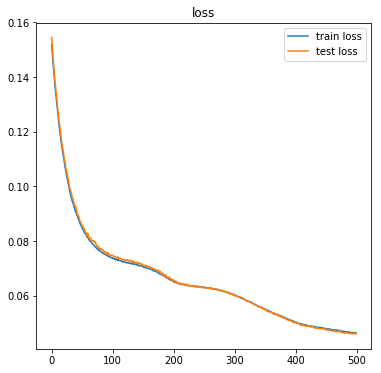

In [20]:
plt.figure(figsize=(6,6))

plt.plot(range(EPOCH), trainLoss)
plt.plot(range(EPOCH), testLoss)
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss.png")

Plot the some output result of the network as an image.

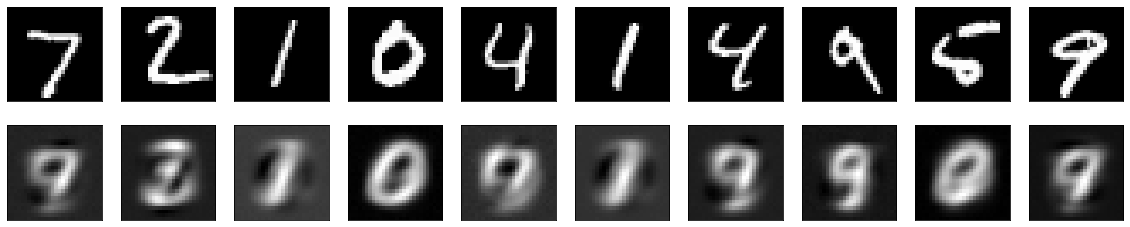

In [25]:
result_train = np.zeros((datasizeTrain, 1, 28, 28))
result_test = np.zeros((datasizeTest, 1, 28, 28))

#Get network output for train data.
for i in range(0, datasizeTrain, BATCH_SIZE):
    xBatch = dataTrain[i:i+BATCH_SIZE]
    if torch.cuda.is_available():
        xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
    else:
        xBatch = torch.from_numpy(xBatch.copy()).float()
    re = net(xBatch)
    if torch.cuda.is_available():
        result_train[i:i+BATCH_SIZE] = re.to('cpu').data
    else:
        result_train[i:i+BATCH_SIZE] = re.data

#Get network output for test data.
for i in range(0, datasizeTest, BATCH_SIZE):
    xBatch = dataTest[i:i+BATCH_SIZE]
    if torch.cuda.is_available():
        xBatch = torch.from_numpy(xBatch.copy()).float().to('cuda')
    else:
        xBatch = torch.from_numpy(xBatch.copy()).float()
    re = net(xBatch)

    if torch.cuda.is_available():
        result_test[i:i+BATCH_SIZE] = re.to('cpu').data
    else:
        result_test[i:i+BATCH_SIZE] = re.data

  
#Save the image.
#for i in range(datasizeTrain):
#	pic = result_train[i]
#	pic= pic.reshape((28,28))
#	io.imsave("./imgtrain%d.png"%i, pic)


#for i in range(datasizeTest):
#	pic = result_test[i]
#	pic= pic.reshape((28,28))
#	io.imsave("./imgtest%d.png"%i, pic)


# display the images
#%matplotlib inline
#import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(dataTest[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(result_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()